# Make thickness histograms
for AH Manuscript 2022

This code reloads the bars pcied using the bar picker code and reprocesses them to extract also the topography (xy_strat) so that you can calculate bed elevation change

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import copy
import seaborn as sns
from copy import deepcopy
from scipy import interpolate
from shapely.geometry import Polygon, MultiPolygon

In [2]:
## import cropping data for the packages.
filenm = 'agubh2-250mint'+'.xlsx'
mypath = f'/Volumes/SAF_Data/NAYS2DH_files/Data/BarCSVs/concat-files/{filenm}'
allbars = pd.read_excel(mypath, header=0, usecols = 'A:J') ## change if you add more columns to the raw dataset

### locate arrays
arrayfolder = 'agubh2_agu22-250m'
tpo_savefol = 'agubh2_agu22_250tpo'
aftertpo_savefol = 'agubh2_agu22_after250tpo'
init = f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/{arrayfolder}'

## import datamaster so you ca build the sections
idf = '0hfld' #identifier/classifier about the flood setting
intstring = '2hour' #time interval of output
nickname = 'agubh2-10km' #model nickname, agubh2, gentle_wide etc
floodname ='_0hrflood'
eqt = 65

datnam = f'{idf}-datamaster-{intstring}-ud.npy' #name of the data file to upload
dataloc = f'data-{nickname}{floodname}' #where csv files are

datamaster = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}', allow_pickle = True)

## build a library of sections to crop--check the array folder and get ilocs
sectionlist = [int(i) for i in os.listdir(init)]


In [3]:
gridx = 1001
gridy = 26

datacond = 1
if datacond == 1:
    cells = gridy
else:
    cells = gridx
length = 1001 #length of the domain in the x direction
erostart = 5
erostop = 5

num_timesteps = datamaster.shape[2] ##### or 168 for 2 weeks# len(os.listdir(filepathcore))-1 ###when u want to stop plotting

datamaster = datamaster[:, :, :num_timesteps]
# position = np.arange(0, length, dtype = float)
# coevelev = np.empty([num_timesteps])
# interval_to_plot = 120/60 #we want to plot every ___  HOURS 
end_t = num_timesteps #len(np.arange(1, num_timesteps, skipstep)) #number of timesteps in data master array
# fldstart = ((thot_SS+fldstart_s)/3600)/interval_to_plot ###flood starttime, s
spacing = 1

In [4]:
for iloc in sectionlist:

    remove_ilocs = np.where(datamaster[:, 0, :] != iloc)
    data = np.delete(datamaster, remove_ilocs[0], axis=0)
    for i in range (0, num_timesteps):
        data[:, :, i] = data[:, :, i][np.argsort(data[:, :, i][:, 3])]

    stratigraphy = np.empty([end_t, cells]) ###will hold data for topography accounting for changes due to erosion

    stratigraphy_idx = stratigraphy.copy()

    runtime = len(stratigraphy)

    xposition =  stratigraphy.copy()

    in_section = np.where(datamaster[:, 0, -1]==iloc)
    in_section = in_section[0]
    bankpos = datamaster[:, 3, :][in_section]

    rightbank = bankpos.min() ###negativee
    leftbank = bankpos.max() #positive

    xy_strat = np.empty([end_t, int(3+np.round((leftbank-rightbank)/spacing, 0))]) # will put stratigraphies here, in proper x pos

    xy_strat[:] = np.nan

    for time in range (0, data.shape[2]): #TIME
        stratigraphy[time, :] = data[:, 7, time] #elevation change, elevation in 5
        ypos = data[:, 3, time]-rightbank #coreect supid centreline indexing
        xposition[time, :] = ypos

    stratigraphy_idx = stratigraphy.copy()

    for t in range (0, end_t):

        for idx, x in zip(np.arange(0, stratigraphy.shape[1]), xposition[t, :]):
            x = int(np.floor(x)) #rounding down positions, making integers so can use as index
            xy_strat[t, x] = stratigraphy[t, idx]
    xy_topo = np.empty_like(xy_strat)
    xy_topo[:] = np.nan
    for t in range (0, end_t):
        length = int(np.floor(xposition[t, -1]-xposition[t, 0])) #length of the section at time, t
        pos = np.linspace(0, length, length) #create a metre scale array with each x pos = location
        dataint = np.arange(xposition[t, 0], np.round(xposition[t, -1], 0), dtype=int)

        stratnotnan = xy_strat[t, :][~np.isnan(xy_strat[t, :])] #pull out real values of strat
        fx = interpolate.interp1d(xposition[t, :], stratnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #stratigraphy interpolation

        xy_topo[t, dataint] = fx(dataint) #reassign strat

    stratcondition = np.zeros_like(xy_topo)
    stratcondition[:] = np.nan
    erosurf = np.empty([end_t, xy_topo.shape[1]])
    erosurf[:] = np.nan
    ages = np.empty_like(xy_strat)
    strat = deepcopy(xy_topo)

    abc = allbars[allbars['iloc']==iloc].index ## get indi ces of ilocs that correspond to this iloc

    for i in abc:
        arrnm = allbars['array name'].iloc[i]
        start = allbars['StartTime'].iloc[i]
        end = allbars['EndTime'].iloc[i]+1
        left = allbars['LeftEdge'].iloc[i]
        right = allbars['RightEdge'].iloc[i]+1

        xy_stratc = strat[start:end, left:right]
        xy_strata = strat[end-1:, left:right]

        if not os.path.exists(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/{tpo_savefol}/{iloc}'):
            os.makedirs(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/{tpo_savefol}/{iloc}')

        np.save(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/{tpo_savefol}/{iloc}/{arrnm}', xy_stratc, allow_pickle=True)
        
        if not os.path.exists(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/{aftertpo_savefol}/{iloc}'):
            os.makedirs(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/{aftertpo_savefol}/{iloc}')

        np.save(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/{aftertpo_savefol}/{iloc}/{arrnm}', xy_strata, allow_pickle=True)
    
    print(iloc)


100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900


arr = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/agubh2_agu22/{iloc}/{arrnm}.npy', allow_pickle = True)
arrnc = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/{tpo_savefol}/{iloc}/{arrnm}.npy', allow_pickle = True)

In [14]:
arrnc = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/{tpo_savefol}/{iloc}/{arrnm}.npy', allow_pickle = True)

#### Load sections and plot a histogram of dz for:

In [272]:
len(seclist
   )

16

(1) each timestep
(2) each package

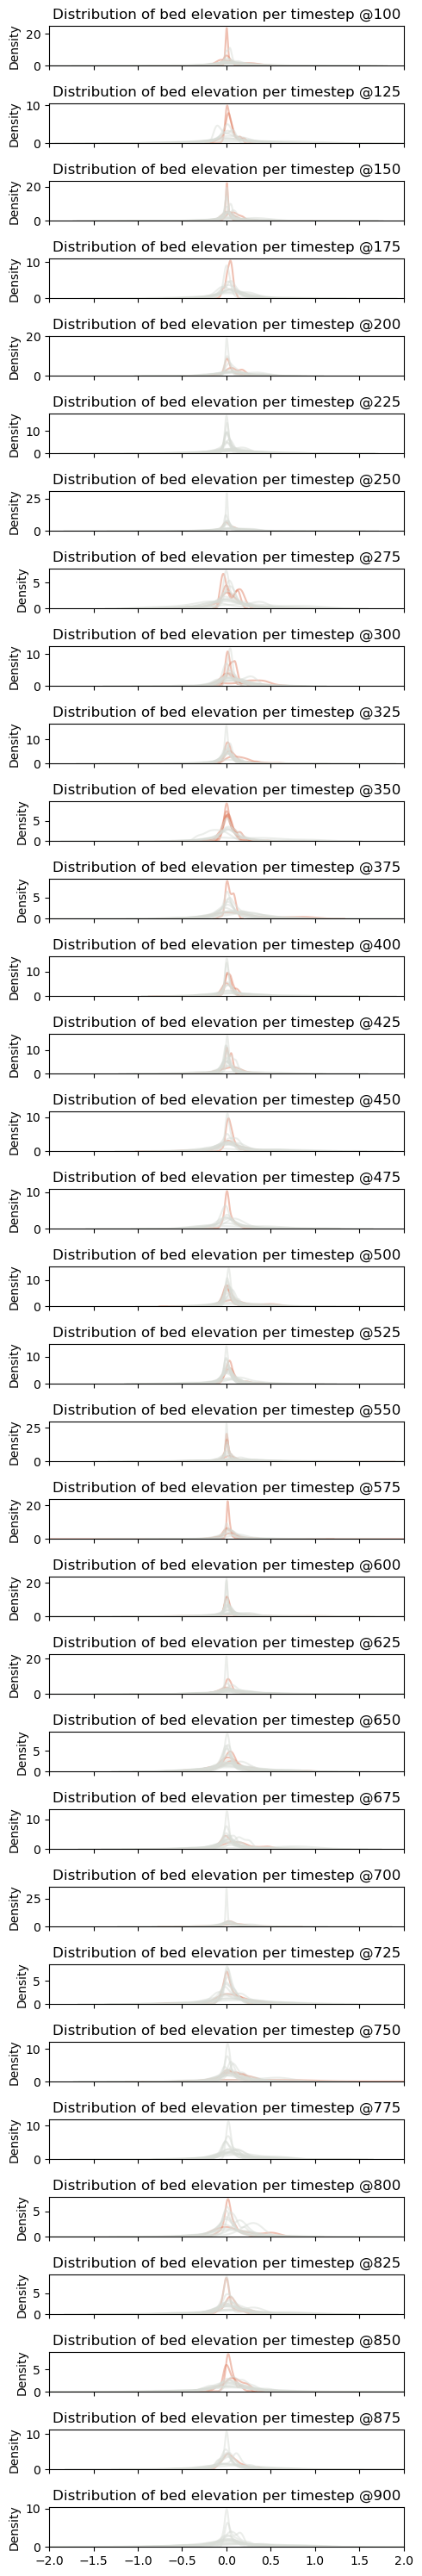

In [22]:
# seclist = np.arange(100, 900, 50)
# seclist = [300, 350]
seclist = copy.deepcopy(sectionlist)
# fig1, (ax1, ax2) = plt.subplots(len(seclist), 1, tight_layout = True, dpi = 100, figsize = (15, 5))
# fig2, (ax1, ax2) = plt.subplots(len(seclist), 1, tight_layout = True, dpi = 100, figsize = (15, 5))
# fig2, ax2 = plt.subplots(len(seclist), 1, tight_layout = True, sharex = True, sharey = True, dpi = 100, figsize = (15, 5))
fig, ax = plt.subplots(len(seclist), 1, sharex = True, tight_layout = True, dpi = 100, figsize = (5, 30))
ax = ax.ravel()
# for secloc in seclist:
for a, secloc in zip(ax, seclist):
    # fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, tight_layout = True, dpi = 100, figsize = (15, 5))
    init = f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/{tpo_savefol}/{secloc}'
    for file in os.listdir(init):

        if 'TR-' in file:
            arr = np.load(os.path.join(init, file), allow_pickle = True)
            thick = arr[1:]-arr[:-1]
            # a2.hist(thick.ravel(), bins = np.arange(-2, 2, 0.05), color = 'xkcd:light grey', edgecolor = 'k', alpha = 0.1) ## histo for all thickness across the pkg
            # a2.hist(arr[0].ravel(), bins = np.arange(-2, 4, 0.05), color = 'xkcd:light grey', histtype = 'step', alpha = 1, density = True)
            # a2.axvspan(np.nanmin(arr[0]), np.nanmax(arr[0]), ymin = 0, ymax = 10, color = 'xkcd:light grey', alpha = 0.5)
            #sns.histplot(thick.ravel(), bins = np.arange(-5, 5, 0.1), color = 'xkcd:light grey', edgecolor = 'k', alpha = 0.25, stat = 'probability', ax = a)
            sns.kdeplot(thick.ravel(), color = 'xkcd:light grey', alpha = 0.5, ax = a)
            #sns.histplot(arr[0].ravel(), bins = np.arange(-5, 5, 0.1), color = 'xkcd:light grey', edgecolor = 'c', alpha = 0.25, stat = 'probability', ax = ax2)
            # sns.histplot(thick.ravel(), bins = np.arange(-5, 5, 0.1), color = 'xkcd:light grey', edgecolor = 'k', alpha = 0.25, stat = 'probability', ax = ax1)
            
#             ax1.hist(thick.ravel(), bins = np.arange(-5, 5, 0.05), color = 'xkcd:light grey', edgecolor = 'k', alpha = 0.25, density = True, stacked = True) ### histo of thickness change 

        if 'FP-' in file:
            arr = np.load(os.path.join(init, file), allow_pickle = True)
            thick = arr[1:]-arr[:-1]
            # sns.histplot(thick.ravel(), bins = np.arange(-5, 5, 0.1), color = '#e08266', edgecolor = 'k', alpha = 0.5, stat = 'probability', ax = a)
            # sns.histplot(arr[0].ravel(), bins = np.arange(-5, 5, 0.1), color = '#e08226', edgecolor = 'm', alpha = 0.25, stat = 'probability', ax = ax2)
            sns.kdeplot(thick.ravel(), color = '#e08266', alpha = 0.5, ax = a)
            # sns.histplot(thick.ravel(), bins = np.arange(-5, 5, 0.1), color = '#e08266', edgecolor = 'k', alpha = 0.5, stat = 'probability', ax = ax1)
#             ax2.hist(arr[1:].ravel(), bins = np.arange(-5, 5, 0.05), color = '#e08266', edgecolor = 'k', alpha = 0.5, density = True, stacked = True)
#             ax1.hist(thick.ravel(), bins = np.arange(-2, 2, 0.05), color = '#e08266', edgecolor = 'k', alpha = 0.5, stacked = True)
                    
        # ax1.set_title(f'Distribution of thickness change per timestep @{secloc}')
        a.set_title(f'Distribution of bed elevation per timestep @{secloc}')
        a.set_xlim(-2, 2)

#### Plot of elevation change after deposition for fully and partially preserved packages

In [17]:
## make plot that shows bounds between bins per section
nbins = np.arange(-2, 2, 0.05)
# seclist = deepcopy(sectionlist)#[100, 200]
fpbins_store_min = np.empty([len(seclist), len(np.arange(-2, 2, 0.05))]) ##store the values of every histogram for fp packages in the section
fpbins_store_max = np.empty([len(seclist), len(np.arange(-2, 2, 0.05))]) ##store the values of every histogram for fp packages in the section

trbins_store_min = np.empty([len(seclist), len(np.arange(-2, 2, 0.05))]) ##store the values of every histogram for fp packages in the section
trbins_store_max = np.empty([len(seclist), len(np.arange(-2, 2, 0.05))]) ##store the values of every histogram for fp packages in the section


# fig, ax = plt.subplots(len(seclist), 1, tight_layout = True, sharex = True, sharey = True, dpi = 100, figsize = (5, 20))
# ax = ax.ravel()


for row, secloc in enumerate(seclist):

    sec_fp_freqs = np.expand_dims(np.empty([len(np.arange(-2, 2, 0.05))-1]), axis = 0)
    sec_fp_freqs[:] = np.nan
    sec_tr_freqs = np.expand_dims(np.empty([len(np.arange(-2, 2, 0.05))-1]), axis = 0)
    sec_tr_freqs[:] = np.nan
    init = f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/{tpo_savefol}/{secloc}'
    for file in os.listdir(init):

        if 'FP-' in file:
            arr = np.load(os.path.join(init, file), allow_pickle = True)
            thick = arr[1:]-arr[:-1]

            for i in range(thick.shape[0]):
                ffreq, fbins = np.histogram(thick[i], bins = np.arange(-2, 2, 0.05))
                ffreq = np.expand_dims(ffreq, axis = 0)
                sec_fp_freqs = np.concatenate((sec_fp_freqs, ffreq), axis = 0)
                # print('newnew', sec_fp_freqs)
                # a.hist(thick[i], bins = np.arange(-2, 2, 0.05), histtype = 'step', edgecolor = '#e08266', alpha = 0.1)
        if 'TR-' in file:
            arr = np.load(os.path.join(init, file), allow_pickle = True)
            thick = arr[1:]-arr[:-1]
            for i in range(thick.shape[0]):
                tfreq, tbins = np.histogram(thick[i], bins = np.arange(-2, 2, 0.05))
                tfreq = np.expand_dims(tfreq, axis = 0)
                sec_tr_freqs = np.concatenate((sec_tr_freqs, tfreq), axis = 0)

                # a.hist(thick[i], bins = np.arange(-2, 2, 0.05), histtype = 'step', edgecolor = 'k', alpha = 0.05)

        ## find min and max values for all sections

    sec_fmin = np.nanmin(sec_fp_freqs, axis = 0)
    sec_fmax = np.nanmax(sec_fp_freqs, axis = 0)
    sec_tmin = np.nanmin(sec_tr_freqs, axis = 0)
    sec_tmax = np.nanmax(sec_tr_freqs, axis = 0)

    # print(sec_fmin)
    ## update the database for all sections
    fpbins_store_min[row, 1:] = sec_fmin
    fpbins_store_max[row, 1:] = sec_fmax

    trbins_store_min[row, 1:] = sec_tmin
    trbins_store_max[row, 1:] = sec_tmax
    
    # print(row, secloc)    
    fpbins_store_min[row, 0] = secloc
    fpbins_store_max[row, 0] = secloc
    trbins_store_min[row, 0] = secloc
    trbins_store_max[row, 0] = secloc

/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_71645/710150002.py:46: RuntimeWarning: All-NaN slice encountered
  sec_fmin = np.nanmin(sec_fp_freqs, axis = 0)
/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_71645/710150002.py:47: RuntimeWarning: All-NaN slice encountered
  sec_fmax = np.nanmax(sec_fp_freqs, axis = 0)


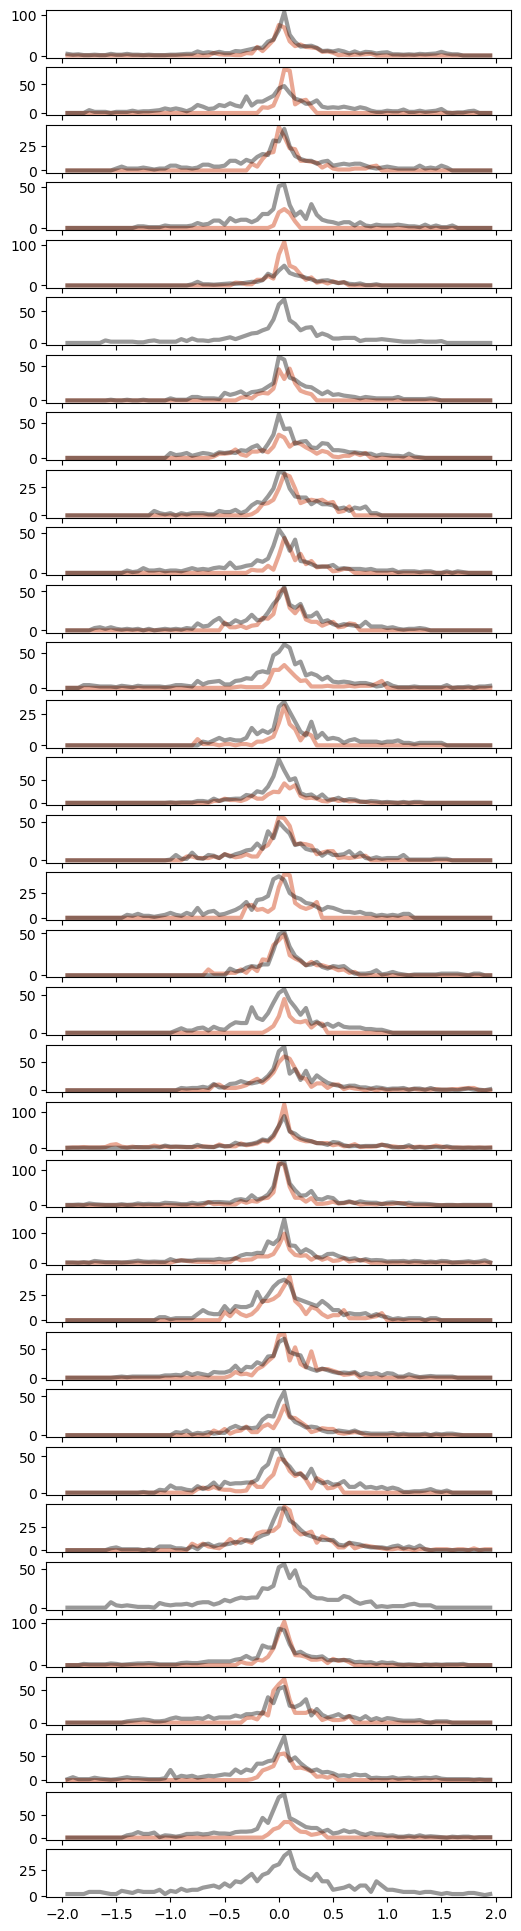

In [18]:
fig, ax = plt.subplots(len(seclist), 1, figsize = (6, 25), dpi = 100)

for row, a in enumerate(ax):
    a.plot(nbins[1:], fpbins_store_max[row, 1:], c = '#e08266', lw = 3, alpha = 0.7)
    a.plot(nbins[1:], trbins_store_max[row, 1:], c = 'k', lw = 3, alpha = 0.4)
# plt.plot(nbins[1:], fpbins_store_max[0, 1:])
# plt.plot(nbins[1:], fpbins_store_max[1, 1:])

# plt.plot(nbins[1:], fpbins_store_min[0, 1:], ls = '--')
# plt.plot(nbins[1:], fpbins_store_min[1, 1:], ls = '--')

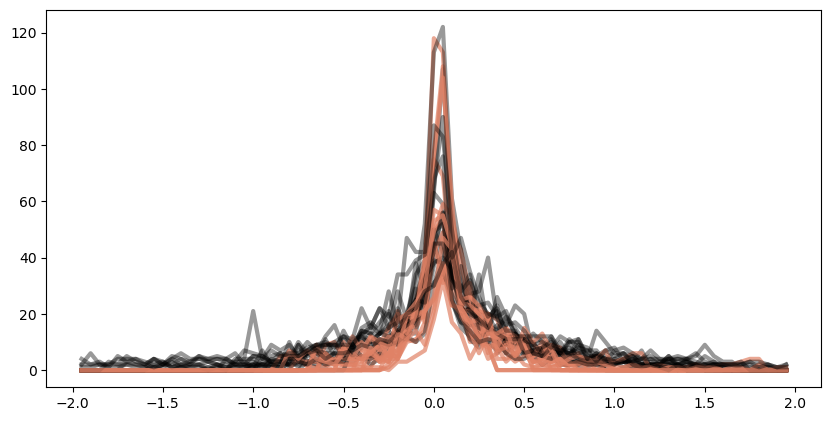

In [179]:
plt.figure(figsize = (10, 5), dpi = 100)
for row, a in enumerate(ax):
    plt.plot(nbins[1:], fpbins_store_max[row, 1:], c = '#e08266', lw = 3, alpha = 0.7)
    plt.plot(nbins[1:], trbins_store_max[row, 1:], c = 'k', lw = 3, alpha = 0.4)